In [ ]:
from collections import Counter
from google.colab import drive
from prettytable import PrettyTable
from sklearn.manifold import TSNE
from torch import nn

import math
import matplotlib.pyplot as plt
import numpy as np
import random
import plotly.graph_objects as go
import statistics
import torch

In [ ]:
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Experiments/context-projections-clustering
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Experiments/context-projections-clustering
model1	model2	model3	text8


# Model Class

In [ ]:
class Model(torch.nn.Module):

  def __init__(self, n_embed, word2id):
    super().__init__()

    self.word2id = word2id
    self.id2word = {id : word for word, id in word2id.items()}

    self.n_vocab = len(word2id)
    self.n_embed = n_embed

    self.in_embed = nn.Embedding(self.n_vocab, n_embed, dtype=torch.float64)
    self.out_embed = nn.Embedding(self.n_vocab, n_embed, dtype=torch.float64)

    self.in_embed.weight.data.uniform_(-1, 1)
    self.out_embed.weight.data.uniform_(-1, 1)

  def forward_input(self, input_words): # takes a batch of input words and returns their embeddings.
    input_vector = self.in_embed(input_words)
    return input_vector

  def forward_output(self, output_words): # takes a batch of output words and returns their embeddings.
    output_vector = self.out_embed(output_words)
    return output_vector

  def input_embeddings(self): # returns the input embeddings as a numpy array
    return self.in_embed.weight.data.cpu().numpy()

  def output_embeddings(self): # returns the output embeddings as a numpy array
    return self.out_embed.weight.data.cpu().numpy()

  def embedding_input_dictionary(self): # return dictionary that map words to their corresponding input embeddings
    embedding = self.in_embed.weight.cpu().data.numpy()
    E = { w : embedding[wid] for wid, w in self.id2word.items()}
    return E

  def embedding_output_dictionary(self): # return dictionary that map words to their corresponding input embeddings
    embedding = self.out_embed.weight.cpu().data.numpy()
    E = { w : embedding[wid] for wid, w in self.id2word.items()}
    return E

  def get_target_embedding(self, word): # return target embedding of given word
    try:
      embedding = self.embedding_input_dictionary()
      return embedding[word]
    except KeyError:
      print("Word not defined.")
      return

  def get_context_embedding(self, word): # return target embedding of given word
    try:
      embedding = self.embedding_output_dictionary()
      return embedding[word]
    except KeyError:
      print("Word not defined.")
      return

  def cosine_similarity(self, v1, v2):
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
      x = v1[i]
      y = v2[i]
      sumxx += x * x
      sumyy += y * y
      sumxy += x * y
    return sumxy / math.sqrt(sumxx * sumyy)

  def neighbors_from_word(self, word, return_scores = False, topk = 10):
    word_to_embeddings = self.embedding_input_dictionary()
    neighbor_words = ["<NULL>"] * topk
    neighbor_similarities = [-1.0] * topk
    min_neighbor = neighbor_similarities.index(min(neighbor_similarities))
    if word not in list(word_to_embeddings.keys()):
      return neighbor_words, neighbor_similarities
    input_emb = word_to_embeddings[word]
    for w in word_to_embeddings.keys():
      word_emb = word_to_embeddings[w]
      sim = self.cosine_similarity(input_emb, word_emb)
      if sim >= neighbor_similarities[min_neighbor]:
        neighbor_similarities[min_neighbor] = sim
        neighbor_words[min_neighbor] = w
        min_neighbor = neighbor_similarities.index(min(neighbor_similarities))
    if return_scores:
      return neighbor_words, neighbor_similarities
    else:
      return neighbor_words

  def save_model(self, name):
    torch.save(self, name)


# Functions

In [ ]:
def cosine_similarity(v1, v2):
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i];
        y = v2[i]
        sumxx += x * x
        sumyy += y * y
        sumxy += x * y
    return sumxy / math.sqrt(sumxx * sumyy)

In [ ]:
def orthogonal_projection_position(word1, word2, w1_vectors, w2_vectors):

  if (word1 not in list(w1_vectors.keys())) or (word2 not in list(w2_vectors.keys())):
    return -100

  v1 = w1_vectors[word1]
  v2 = w2_vectors[word2]

  # Calculate the dot product of v1 and v2
  dot_product = np.dot(v1, v2)

  # Calculate the magnitude of v1
  v1_magnitude = np.linalg.norm(v1)

  # Calculate the position of the orthogonal projection
  position = dot_product / v1_magnitude

  return position

# Read Text

In [ ]:
def preprocess(text):

  # lowercase
  text = text.lower()

  # separate these punctuation marks from the words in the text and allow the model to treat them differently.
  text = text.replace('.', ' <PERIOD> ')
  text = text.replace(',', ' <COMMA> ')
  text = text.replace('"', ' <QUOTATION_MARK> ')
  text = text.replace(';', ' <SEMICOLON> ')
  text = text.replace('!', ' <EXCLAMATION_MARK> ')
  text = text.replace('?', ' <QUESTION_MARK> ')
  text = text.replace('(', ' <LEFT_PAREN> ')
  text = text.replace(')', ' <RIGHT_PAREN> ')
  text = text.replace('--', ' <HYPHENS> ')
  text = text.replace('?', ' <QUESTION_MARK> ')
  text = text.replace('\n', ' <NEW_LINE> ')
  text = text.replace(':', ' <COLON> ')

  # splits the text into individual words
  words = text.split()

  # remove words with five or fewer occurrences. reduce the size of the vocabulary and improve the efficiency of the model.
  word_counts = Counter(words)  # dictionary word:occurrences
  trimmed_words = [word for word in words if word_counts[word] > 5] # Remove any word fewer than 5 tokens

  # remove common words that do not provide much meaning to the text
  stop = [
  "a", "about", "above", "after", "again", "against", "all", "also", "altough", "am", "an", "and", "any", "are", "aren't", "as", "at",
  "b", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by",
  "c", "can", "can't", "cannot", "could", "couldn't",
  "d", "de", "did", "didn't", "do", "does", "doesn't", "doing", "don't", "down", "during",
  "e", "each", "either", "even",
  "f", "few", "for", "from", "further",
  "g",
  "h", "had", "hadn't", "has", "hasn't", "have", "haven't", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's",
  "hers", "herself", "him", "himself", "his", "how", "how's", "however",
  "i", "i'd", "i'll", "i'm", "i've", "if", "ii", "in", "into", "is", "isn't", "it", "it's", "its", "itself",
  "j", "just",
  "k",
  "l", "like",
  "m", "many", "may", "me", "more", "most", "much", "must", "my", "myself",
  "n", "nd", "neither", "no", "nor", "not", "now",
  "o", "of", "off", "on", "once", "only", "or", "other", "our", "ours", "ourselves", "out", "over", "own",
  "p",
  "q",
  "r", "rd",
  "s", "same", "shall", "she", "she'd", "she'll", "she's", "should", "shouldn't", "so", "some", "such",
  "t", "th", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they",
  "they'd", "they'll", "they're", "they've", "this", "those", "though", "through", "to", "too",
  "u", "under", "until", "up", "us",
  "v", "very",
  "w", "was", "wasn't", "we", "we'd", "we'll", "we're", "we've", "were", "weren't", "what", "what's", "when", "when's", "where",
  "where's", "which", "while", "who", "who's", "whom", "why", "why's", "will", "with", "won't", "would", "wouldn't",
  "x",
  "y", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves",
  "z",
  "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten", "eleven", "twelve"
  ]

  stop_trimmed_words = [w for w in trimmed_words if w not in stop]

  return stop_trimmed_words

In [ ]:
with open('text8') as f:
    text = f.read()

words = preprocess(text)

print("Total words in text: %d" % (len(words)))
print("Unique words in text: %d" % (len(set(words))))

Total words in text: 8448361
Unique words in text: 63459


## Choosing Test Words

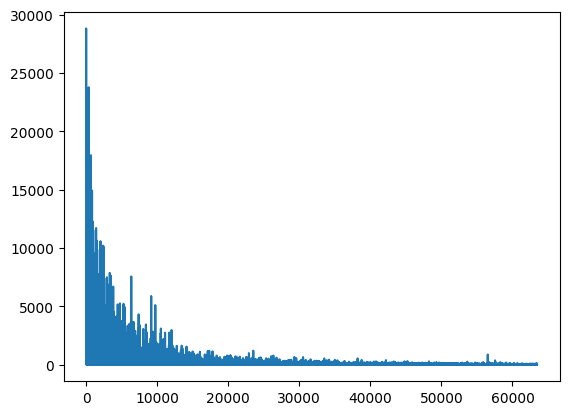

In [ ]:
counter = Counter(words)
plt.plot(range(len(counter.keys())), counter.values())
plt.show()

In [ ]:
test_indexes = np.random.choice(range(500, 5000), size=(100))
test_words = [list(counter.keys())[i] for i in test_indexes]

print("Five of the picked test words: ", test_words[50:55])

Five of the picked test words:  ['saving', 'ne', 'experiences', 'saw', 'whig']


In [ ]:
test_dict = {x : {"pos" : list(), "neg" : list()} for x in test_words}
window_size = 3
neg_sample = 3

for idx, w in enumerate(words):
  if w in test_words:
    start , end = max(0 , idx-window_size) , min(len(words)-1 , idx+window_size) + 1
    ctx_samples = [s for s in words[start:idx] + words[idx+1:end] if s != w]
    test_dict[w]["pos"].extend(ctx_samples)
    neg_size = len(ctx_samples) * neg_sample
    test_dict[w]["neg"].extend(random.choices(words, k = neg_size))

nr_contexts , nr_noises = 40 , 60
test_dict = {key: {"pos" :  [i[0] for i in Counter(value["pos"]).most_common(nr_contexts)], "neg" : random.choices(value["neg"], k=nr_noises)} for key, value in test_dict.items()}
print(list(test_dict.items())[50])

('saving', {'pos': ['time', 'life', 'daylight', 'lives', 'thus', 'investment', 'grace', 'excessive', 'god', 'world', 'people', 'faith', 'keynes', 'day', 'purpose', 'well', 'christ', 'weight', 'property', 'money', 'private', 'fall', 'interest', 'instead', 'cost', 'new', 'dead', 'space', 'first', 'son', 'ryan', 'rj', 'makes', 'country', 'problem', 'bandwidth', 'distress', 'disk', 'jesus', 'power'], 'neg': ['time', 'aimed', 'chosen', 'text', 'justin', 'composer', 'years', 'combat', 'best', 'mitnick', 'beliefs', 'prepaid', 'properly', 'american', 'back', 'map', 'organization', 'holding', 'due', 'mountain', 'back', 'afflicted', 'break', 'nazi', 'damage', 'industry', 'heller', 'arose', 'controversy', 'southern', 'join', 'new', 'amir', 'moore', 'disorders', 'understanding', 'tangent', 'pop', 'brugha', 'list', 'motion', 'regular', 'organization', 'technical', 'establishment', 'strong', 'catholic', 'battles', 'miscellaneous', 'permutation', 'large', 'closely', 'join', 'sanguine', 'green', 'sulf

# Model 1

In [ ]:
models1 = [torch.load('model1/epoch_%d.torch' % x, map_location=torch.device('cpu')) for x in range(1,7)]

## Stats

In [ ]:
stats_table = PrettyTable()
stats_table.field_names = ["Target", "1", "2", "3", "4", "5", "6"]

stats_dict = {model_idx+1: {"avg_proj_1":-1, "avg_noise_proj":-1, "var_proj_1":-1, "proj_diff":-1, "avg_sim":-1, "avg_mag":-1} for model_idx in range(len(models1))}

for model_idx in range(len(models1)):

  trg_emb = models1[model_idx].embedding_input_dictionary()
  ctx_emb = models1[model_idx].embedding_output_dictionary()

  avg_proj_1, noise_proj, var_proj_1, proj_diff, avg_sim, magnitudes = list(), list(), list(), list(), list(), list()

  for word, samples in test_dict.items():

    contexts = samples["pos"]
    noises = samples["neg"]

    projections1 = [orthogonal_projection_position(word, context, trg_emb, ctx_emb) for context in contexts]
    noise_projections = [orthogonal_projection_position(word, context, trg_emb, ctx_emb) for context in noises]
    similarities = [cosine_similarity(trg_emb[word], trg_emb[context]) for context in contexts]
    magnitude = math.sqrt(sum(i**2 for i in trg_emb[word]))

    avg_proj_1.append(statistics.mean(projections1))
    noise_proj.append(statistics.mean(noise_projections))
    var_proj_1.append(statistics.variance(projections1))
    proj_diff.append((statistics.mean(projections1) - statistics.mean(noise_projections)))
    avg_sim.append(statistics.mean(similarities))
    magnitudes.append(magnitude)

    if model_idx == (len(models1)-1):
      stats_table.add_row([word, statistics.mean(projections1), statistics.mean(noise_projections), statistics.variance(projections1),
                          (statistics.mean(projections1) - statistics.mean(noise_projections)), statistics.mean(similarities), magnitude])


  stats_dict[model_idx+1]["avg_proj_1"] = statistics.mean(avg_proj_1)
  stats_dict[model_idx+1]["avg_noise_proj"] = statistics.mean(noise_proj)
  stats_dict[model_idx+1]["var_proj_1"] = statistics.mean(var_proj_1)
  stats_dict[model_idx+1]["avg_proj_2"] = statistics.mean(proj_diff)
  stats_dict[model_idx+1]["avg_sim"] = statistics.mean(avg_sim)
  stats_dict[model_idx+1]["avg_mag"] = statistics.mean(magnitudes)

### Stats Dictionary
1. Average context (ctx repr.) projections on target (trg repr.)
2. Average noise (ctx repr.) projections on target (trg repr.)
3. Average ***variance*** of context (ctx repr.) projections on target (trg repr.)
4. Average projection **difference** of context (ctx repr.) and noise (ctx repr.) on target (trg repr.)
5. Average ***cos-similarity*** of context (trg repr.) and target (trg repr.)
6. Average target magnitude

In [ ]:
print(stats_table)

+-----------------+----------------------+----------------------+--------------------+---------------------+---------------------+--------------------+
|      Target     |          1           |          2           |         3          |          4          |          5          |         6          |
+-----------------+----------------------+----------------------+--------------------+---------------------+---------------------+--------------------+
|      intact     | -1.6948536489986779  | -2.8202297920583432  | 1.8698227288824283 |  1.1253761430596654 |  0.0626829131539685 | 20.320053769270945 |
|      russia     |   5.15593323872338   |  1.3108115675283425  | 4.998721535996486  |  3.845121671195037  |  0.3356268815622683 | 21.53327672363902  |
|     leonard     |  3.737849257543721   |  1.0669380301020244  | 3.5626652044135008 |  2.670911227441697  |  0.2510974176063922 | 19.615917090109722 |
|     germany     |  1.704410953876716   | -1.3962619755144372  | 4.039307205459731  |  

In [ ]:
for model_idx, values in stats_dict.items():
  print("EPOCH #%d [1: %.3f] [2: %.3f] [3: %.3f] [4: %.3f] [5: %.3f] [6: %.3f] " % (model_idx, values["avg_proj_1"], values["avg_noise_proj"], values["var_proj_1"], values["avg_proj_2"], values["avg_sim"], values["avg_mag"]))

EPOCH #1 [1: 0.333] [2: -0.648] [3: 1.357] [4: 0.981] [5: 0.122] [6: 11.973] 
EPOCH #2 [1: 0.652] [2: -0.984] [3: 2.320] [4: 1.636] [5: 0.175] [6: 13.766] 
EPOCH #3 [1: 0.675] [2: -1.217] [3: 2.792] [4: 1.892] [5: 0.185] [6: 15.370] 
EPOCH #4 [1: 0.709] [2: -1.341] [3: 3.135] [4: 2.050] [5: 0.187] [6: 16.871] 
EPOCH #5 [1: 0.730] [2: -1.408] [3: 3.370] [4: 2.138] [5: 0.185] [6: 18.288] 
EPOCH #6 [1: 0.705] [2: -1.514] [3: 3.555] [4: 2.219] [5: 0.182] [6: 19.623] 


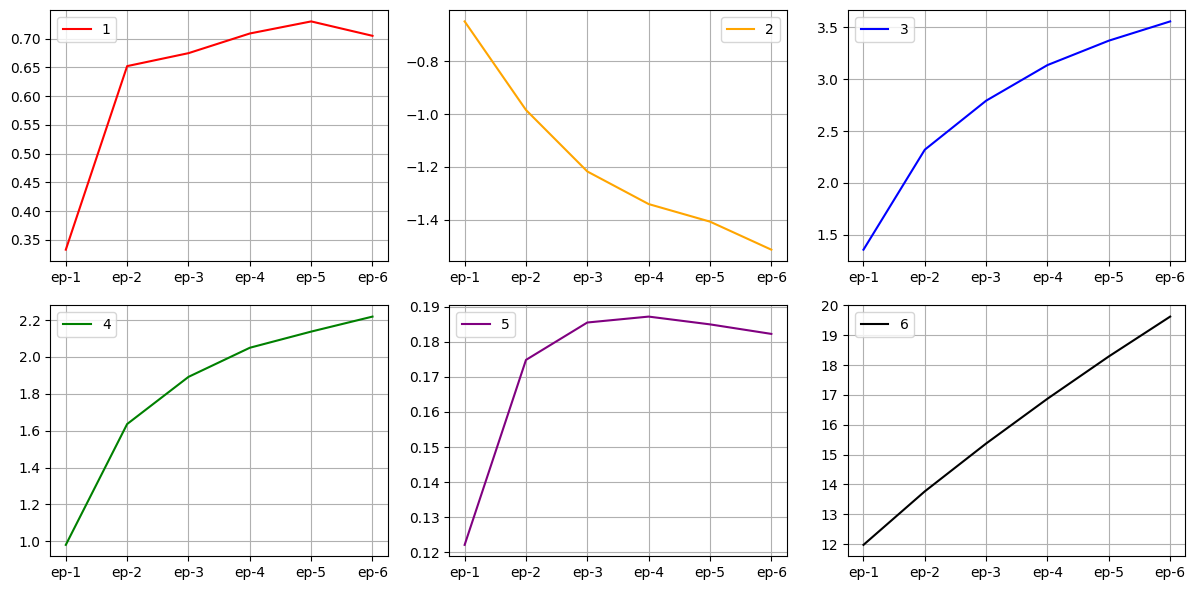

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 6))

ax1.grid(axis='both')
ax1.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_proj_1"] for v in stats_dict.values()], label = "1", color="red")
ax1.legend()

ax2.grid(axis='both')
ax2.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_noise_proj"] for v in stats_dict.values()], label = "2", color="orange")
ax2.legend()

ax3.grid(axis='both')
ax3.plot(["ep-%d"%x for x in stats_dict.keys()], [v["var_proj_1"] for v in stats_dict.values()], label = "3", color="blue")
ax3.legend()

ax4.grid(axis='both')
ax4.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_proj_2"] for v in stats_dict.values()], label = "4", color="green")
ax4.legend()

ax5.grid(axis='both')
ax5.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_sim"] for v in stats_dict.values()], label = "5", color="purple")
ax5.legend()

ax6.grid(axis='both')
ax6.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_mag"] for v in stats_dict.values()], label = "6", color="black")
ax6.legend()

fig.tight_layout()
fig.show()

# Visualize vectors

In [ ]:
test_index = 50

trg = list(test_dict.keys())[test_index]

print("Visuaizing for: %s" % (trg))

Visuaizing for: saving


In [ ]:
tsne = TSNE(n_components=3, perplexity=18, random_state=42)

for idx in range(len(models1)):

  #print("\n\n------ Plot for Epoch #%d ------\n" % (idx+1))

  target_vectors = models1[idx].embedding_input_dictionary()
  context_vectors = models1[idx].embedding_output_dictionary()

  ######################### Dimension Reduction

  vectors = [context_vectors[w] for w in test_dict[trg]["pos"]]
  vectors.extend([context_vectors[w] for w in test_dict[trg]["neg"]])
  vectors.append(target_vectors[trg])

  vectors = tsne.fit_transform(np.array(vectors))
  contexts = vectors[:nr_contexts]
  noises = vectors[nr_contexts:-1]
  target = vectors[-1]

  ########### Plot

  c_x, c_y, c_z = contexts[:, 0], contexts[:, 1], contexts[:, 2]
  n_x, n_y, n_z = noises[:, 0], noises[:, 1], noises[:, 2]
  t_x, t_y, t_z = target[0], target[1], target[2]

  hover_context = test_dict[trg]["pos"]
  hover_noise = test_dict[trg]["neg"]

  fig = go.Figure( data = [ go.Scatter3d( x = c_x, y = c_y, z = c_z, mode='markers',
      marker=dict(size=6, color="green", opacity=0.8),
      text = hover_context, hoverinfo = 'text', name = "Contexts") ] )

  fig.add_trace( go.Scatter3d( x = n_x, y = n_y, z = n_z, mode='markers',
      marker=dict(size=6, color="red", opacity=0.8),
      text = hover_noise, hoverinfo = 'text', name = "Noises" ) )

  fig.add_trace( go.Scatter3d( x=[0, t_x], y=[0, t_y], z=[0, t_z],
      mode='lines', text = trg, hoverinfo='text',
      line=dict(color='blue', width=3), name = trg  ) )

  ########### Add origin
  fig.add_trace( go.Scatter3d( x=[0, 0], y= [0, 0], z=[0, 0], mode='markers', text = "Origin", hoverinfo='text',
      marker=dict(size=5, color="black", opacity=1.0), name = "Origin"  ) )

  fig.update_layout(scene = dict(xaxis_title='x-axis', yaxis_title='y-axis', zaxis_title='z-axis'))
  #fig.show()

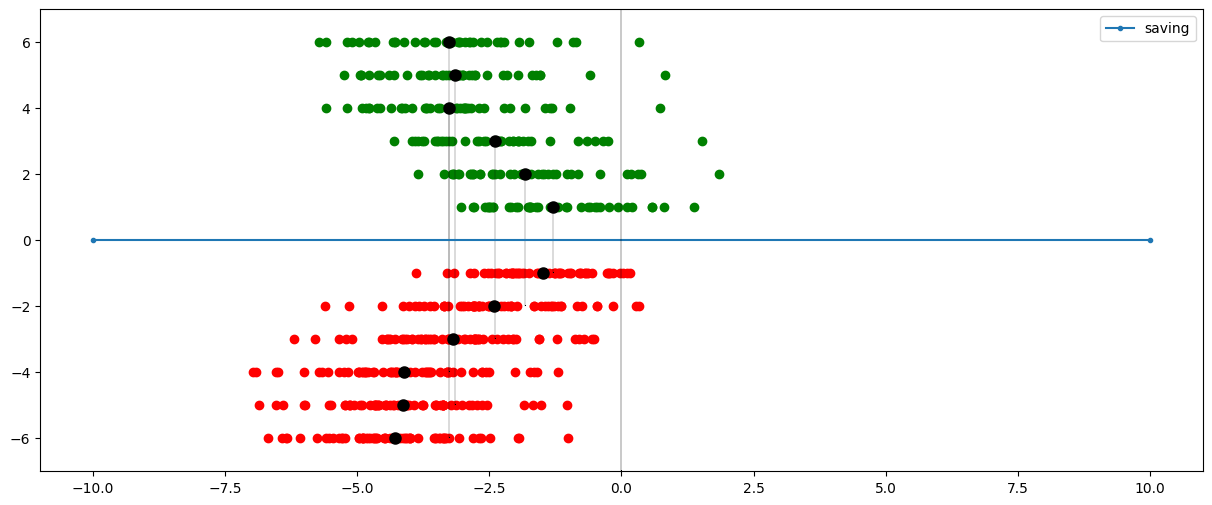

In [ ]:
test_index = 50
trg = list(test_dict.keys())[test_index]
contexts = test_dict[trg]["pos"]
noises = test_dict[trg]["neg"]

plt.figure(figsize=(15,6))

for epoch in range(len(models1)):
  target_vectors = models1[epoch].embedding_input_dictionary()
  context_vectors = models1[epoch].embedding_output_dictionary()

  context_projections = [orthogonal_projection_position(trg, context, target_vectors, context_vectors) for context in contexts]
  noise_projections = [orthogonal_projection_position(trg, context, target_vectors, context_vectors) for context in noises]

  plt.scatter(context_projections, [epoch+1] * len(context_projections), color="green")
  plt.scatter([statistics.mean(context_projections)], [epoch+1], color="black", linewidths=3.0)
  x1, y1 = [statistics.mean(context_projections), statistics.mean(context_projections)], [-(epoch+1), (epoch+1)]
  plt.plot(x1, y1, marker = ',', color="black", linewidth=0.2)

  plt.scatter(noise_projections, [-(epoch+1)] * len(noise_projections), color="red")
  plt.scatter([statistics.mean(noise_projections)], [-(epoch+1)], color="black", linewidths=3.0)

#magnitude = math.sqrt(sum(i**2 for i in target_vectors[trg]))
magnitude = 10.0
x1, y1 = [-magnitude, +magnitude], [0, 0]
plt.plot(x1, y1, marker = '.', label=trg)

x1, y1 = [0, 0], [-(epoch+2), (epoch+2)]
plt.plot(x1, y1, marker = ',', color="black", linewidth=0.3)

plt.legend()
plt.ylim((-(epoch+2), (epoch+2)))
plt.show()

# Model 2

### Galvan loss

In [ ]:
models2 = [torch.load('model2/epoch_%d.torch' % x, map_location=torch.device('cpu')) for x in range(1,7)]

In [ ]:
print("Five of the picked test words: ", test_words[50:55])

Five of the picked test words:  ['saving', 'ne', 'experiences', 'saw', 'whig']


## Stats

In [ ]:
stats_table = PrettyTable()
stats_table.field_names = ["Target", "1", "2", "3", "4", "5", "6"]

stats_dict = {model_idx+1: {"avg_proj_1":-1, "avg_noise_proj":-1, "var_proj_1":-1, "proj_diff":-1, "avg_sim":-1, "avg_mag":-1} for model_idx in range(len(models2))}

for model_idx in range(len(models2)):

  trg_emb = models2[model_idx].embedding_input_dictionary()
  ctx_emb = models2[model_idx].embedding_output_dictionary()

  avg_proj_1, noise_proj, var_proj_1, proj_diff, avg_sim, magnitudes = list(), list(), list(), list(), list(), list()

  for word, samples in test_dict.items():

    contexts = samples["pos"]
    noises = samples["neg"]

    projections1 = [orthogonal_projection_position(word, context, trg_emb, ctx_emb) for context in contexts]
    noise_projections = [orthogonal_projection_position(word, context, trg_emb, ctx_emb) for context in noises]
    similarities = [cosine_similarity(trg_emb[word], trg_emb[context]) for context in contexts]
    magnitude = math.sqrt(sum(i**2 for i in trg_emb[word]))

    avg_proj_1.append(statistics.mean(projections1))
    noise_proj.append(statistics.mean(noise_projections))
    var_proj_1.append(statistics.variance(projections1))
    proj_diff.append((statistics.mean(projections1) - statistics.mean(noise_projections)))
    avg_sim.append(statistics.mean(similarities))
    magnitudes.append(magnitude)

    if model_idx == (len(models1)-1):
      stats_table.add_row([word, statistics.mean(projections1), statistics.mean(noise_projections), statistics.variance(projections1),
                          (statistics.mean(projections1) - statistics.mean(noise_projections)), statistics.mean(similarities), magnitude])


  stats_dict[model_idx+1]["avg_proj_1"] = statistics.mean(avg_proj_1)
  stats_dict[model_idx+1]["avg_noise_proj"] = statistics.mean(noise_proj)
  stats_dict[model_idx+1]["var_proj_1"] = statistics.mean(var_proj_1)
  stats_dict[model_idx+1]["avg_proj_2"] = statistics.mean(proj_diff)
  stats_dict[model_idx+1]["avg_sim"] = statistics.mean(avg_sim)
  stats_dict[model_idx+1]["avg_mag"] = statistics.mean(magnitudes)

### Stats Dictionary
1. Average context (ctx repr.) projections on target (trg repr.)
2. Average noise (ctx repr.) projections on target (trg repr.)
3. Average ***variance*** of context (ctx repr.) projections on target (trg repr.)
4. Average projection **difference** of context (ctx repr.) and noise (ctx repr.) on target (trg repr.)
5. Average ***cos-similarity*** of context (trg repr.) and target (trg repr.)
6. Average target magnitude

In [ ]:
print(stats_table)

+-----------------+-----------------------+------------------------+--------------------+-----------------------+------------------------+--------------------+
|      Target     |           1           |           2            |         3          |           4           |           5            |         6          |
+-----------------+-----------------------+------------------------+--------------------+-----------------------+------------------------+--------------------+
|      intact     |  -0.41127508360570614 |  0.19307998276600177   | 1.3251075138133592 |  -0.6043550663717079  | -0.010071146751349881  | 16.940670406255574 |
|      russia     |  0.24077503977264583  |  -0.18957792080409783  | 2.8732560515514116 |  0.43035296057674366  | 0.0032636819768581474  | 16.502443421914002 |
|     leonard     |   0.4081048810383668  |   0.3485666423175761   | 1.5173252404315445 |  0.05953823872079067  | -0.005197264268793539  | 16.92729009308088  |
|     germany     |  -0.2506084106448147

In [ ]:
for model_idx, values in stats_dict.items():
  print("EPOCH #%d [1: %.3f] [2: %.3f] [3: %.3f] [4: %.3f] [5: %.3f] [6: %.3f] " % (model_idx, values["avg_proj_1"], values["avg_noise_proj"], values["var_proj_1"], values["avg_proj_2"], values["avg_sim"], values["avg_mag"]))

EPOCH #1 [1: 0.016] [2: -0.002] [3: 0.612] [4: 0.018] [5: 0.001] [6: 11.357] 
EPOCH #2 [1: 0.025] [2: 0.001] [3: 0.840] [4: 0.024] [5: 0.001] [6: 12.446] 
EPOCH #3 [1: 0.012] [2: -0.010] [3: 1.065] [4: 0.021] [5: 0.001] [6: 13.476] 
EPOCH #4 [1: 0.005] [2: -0.006] [3: 1.346] [4: 0.011] [5: 0.000] [6: 14.421] 
EPOCH #5 [1: 0.018] [2: -0.010] [3: 1.646] [4: 0.028] [5: 0.000] [6: 15.315] 
EPOCH #6 [1: 0.010] [2: 0.013] [3: 1.921] [4: -0.003] [5: 0.001] [6: 16.131] 


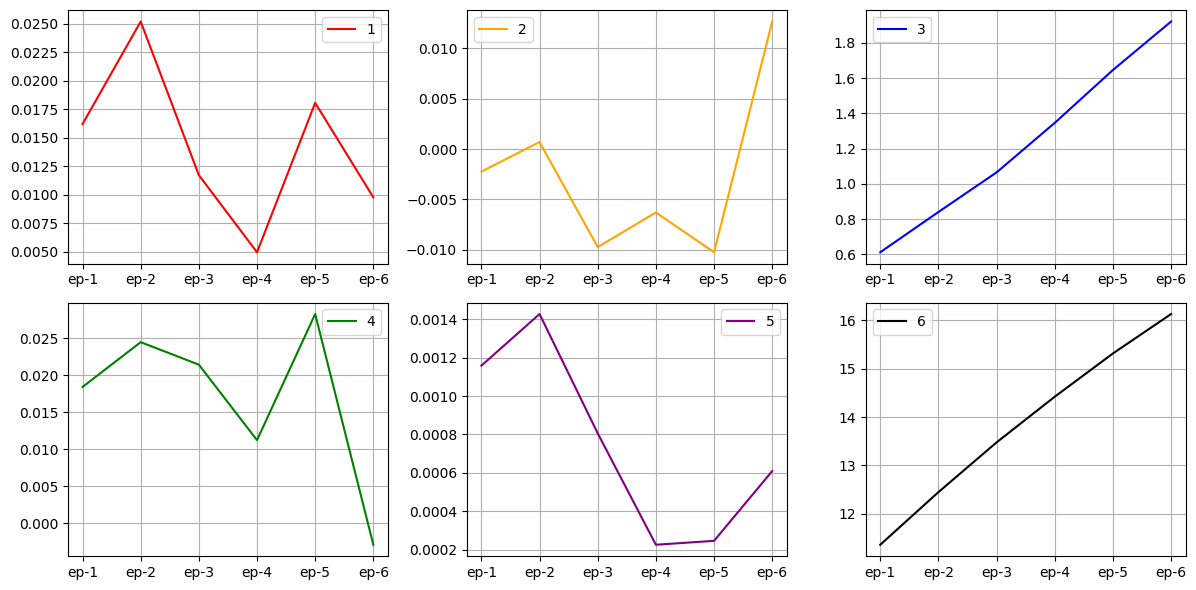

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 6))

ax1.grid(axis='both')
ax1.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_proj_1"] for v in stats_dict.values()], label = "1", color="red")
ax1.legend()

ax2.grid(axis='both')
ax2.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_noise_proj"] for v in stats_dict.values()], label = "2", color="orange")
ax2.legend()

ax3.grid(axis='both')
ax3.plot(["ep-%d"%x for x in stats_dict.keys()], [v["var_proj_1"] for v in stats_dict.values()], label = "3", color="blue")
ax3.legend()

ax4.grid(axis='both')
ax4.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_proj_2"] for v in stats_dict.values()], label = "4", color="green")
ax4.legend()

ax5.grid(axis='both')
ax5.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_sim"] for v in stats_dict.values()], label = "5", color="purple")
ax5.legend()

ax6.grid(axis='both')
ax6.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_mag"] for v in stats_dict.values()], label = "6", color="black")
ax6.legend()

fig.tight_layout()
fig.show()

# Visualize vectors

In [ ]:
test_index = 50

trg = list(test_dict.keys())[test_index]

print("Visuaizing for: %s" % (trg))

Visuaizing for: saving


In [ ]:
tsne = TSNE(n_components=3, perplexity=18, random_state=42)

for idx in range(len(models2)):

  #print("\n\n------ Plot for Epoch #%d ------\n" % (idx+1))

  target_vectors = models2[idx].embedding_input_dictionary()
  context_vectors = models2[idx].embedding_output_dictionary()

  ######################### Dimension Reduction

  vectors = [context_vectors[w] for w in test_dict[trg]["pos"]]
  vectors.extend([context_vectors[w] for w in test_dict[trg]["neg"]])
  vectors.append(target_vectors[trg])

  vectors = tsne.fit_transform(np.array(vectors))
  contexts = vectors[:nr_contexts]
  noises = vectors[nr_contexts:-1]
  target = vectors[-1]

  ########### Plot

  c_x, c_y, c_z = contexts[:, 0], contexts[:, 1], contexts[:, 2]
  n_x, n_y, n_z = noises[:, 0], noises[:, 1], noises[:, 2]
  t_x, t_y, t_z = target[0], target[1], target[2]

  hover_context = test_dict[trg]["pos"]
  hover_noise = test_dict[trg]["neg"]

  fig = go.Figure( data = [ go.Scatter3d( x = c_x, y = c_y, z = c_z, mode='markers',
      marker=dict(size=6, color="green", opacity=0.8),
      text = hover_context, hoverinfo = 'text', name = "Contexts") ] )

  fig.add_trace( go.Scatter3d( x = n_x, y = n_y, z = n_z, mode='markers',
      marker=dict(size=6, color="red", opacity=0.8),
      text = hover_noise, hoverinfo = 'text', name = "Noises" ) )

  fig.add_trace( go.Scatter3d( x=[0, t_x], y=[0, t_y], z=[0, t_z],
      mode='lines', text = trg, hoverinfo='text',
      line=dict(color='blue', width=3), name = trg  ) )

  ########### Add origin
  fig.add_trace( go.Scatter3d( x=[0, 0], y= [0, 0], z=[0, 0], mode='markers', text = "Origin", hoverinfo='text',
      marker=dict(size=5, color="black", opacity=1.0), name = "Origin"  ) )

  fig.update_layout(scene = dict(xaxis_title='x-axis', yaxis_title='y-axis', zaxis_title='z-axis'))
  #fig.show()

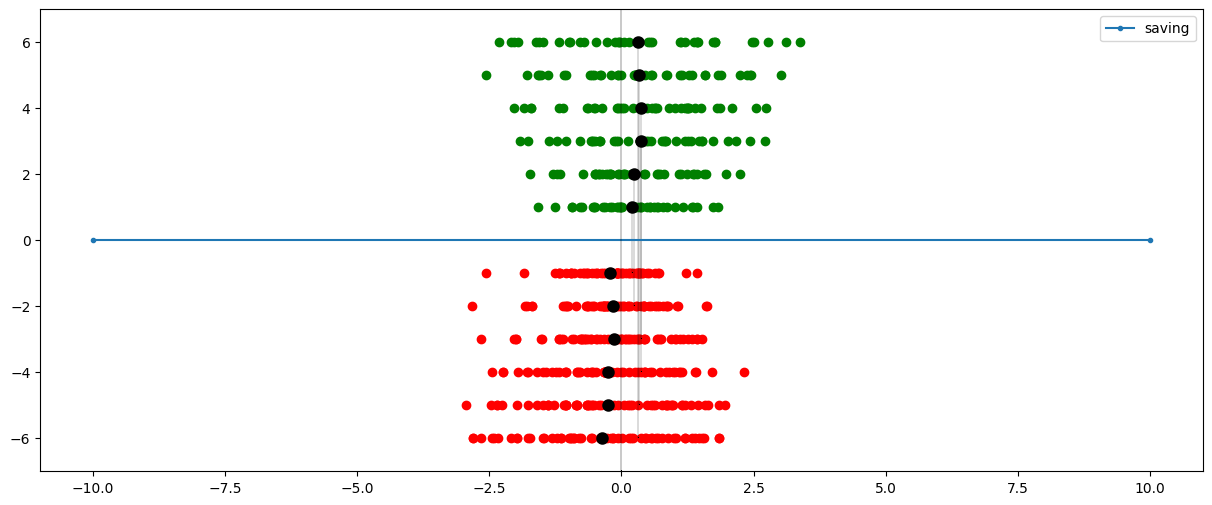

In [ ]:
test_index = 50
trg = list(test_dict.keys())[test_index]
contexts = test_dict[trg]["pos"]
noises = test_dict[trg]["neg"]

plt.figure(figsize=(15,6))

for epoch in range(len(models2)):
  target_vectors = models2[epoch].embedding_input_dictionary()
  context_vectors = models2[epoch].embedding_output_dictionary()

  context_projections = [orthogonal_projection_position(trg, context, target_vectors, context_vectors) for context in contexts]
  noise_projections = [orthogonal_projection_position(trg, context, target_vectors, context_vectors) for context in noises]

  plt.scatter(context_projections, [epoch+1] * len(context_projections), color="green")
  plt.scatter([statistics.mean(context_projections)], [epoch+1], color="black", linewidths=3.0)
  x1, y1 = [statistics.mean(context_projections), statistics.mean(context_projections)], [-(epoch+1), (epoch+1)]
  plt.plot(x1, y1, marker = ',', color="black", linewidth=0.2)

  plt.scatter(noise_projections, [-(epoch+1)] * len(noise_projections), color="red")
  plt.scatter([statistics.mean(noise_projections)], [-(epoch+1)], color="black", linewidths=3.0)

#magnitude = math.sqrt(sum(i**2 for i in target_vectors[trg]))
magnitude = 10.0
x1, y1 = [-magnitude, +magnitude], [0, 0]
plt.plot(x1, y1, marker = '.', label=trg)

x1, y1 = [0, 0], [-(epoch+2), (epoch+2)]
plt.plot(x1, y1, marker = ',', color="black", linewidth=0.3)

plt.legend()
plt.ylim((-(epoch+2), (epoch+2)))
plt.show()

# Model 3

### Only negative loss

In [ ]:
models3 = [torch.load('model3/epoch_%d.torch' % x, map_location=torch.device('cpu')) for x in range(1,7)]

In [ ]:
print("Five of the picked test words: ", test_words[50:55])

Five of the picked test words:  ['saving', 'ne', 'experiences', 'saw', 'whig']


## Stats

In [ ]:
stats_table = PrettyTable()
stats_table.field_names = ["Target", "1", "2", "3", "4", "5", "6"]

stats_dict = {model_idx+1: {"avg_proj_1":-1, "avg_noise_proj":-1, "var_proj_1":-1, "proj_diff":-1, "avg_sim":-1, "avg_mag":-1} for model_idx in range(len(models3))}

for model_idx in range(len(models3)):

  trg_emb = models3[model_idx].embedding_input_dictionary()
  ctx_emb = models3[model_idx].embedding_output_dictionary()

  avg_proj_1, noise_proj, var_proj_1, proj_diff, avg_sim, magnitudes = list(), list(), list(), list(), list(), list()

  for word, samples in test_dict.items():

    contexts = samples["pos"]
    noises = samples["neg"]

    projections1 = [orthogonal_projection_position(word, context, trg_emb, ctx_emb) for context in contexts]
    noise_projections = [orthogonal_projection_position(word, context, trg_emb, ctx_emb) for context in noises]
    similarities = [cosine_similarity(trg_emb[word], trg_emb[context]) for context in contexts]
    magnitude = math.sqrt(sum(i**2 for i in trg_emb[word]))

    avg_proj_1.append(statistics.mean(projections1))
    noise_proj.append(statistics.mean(noise_projections))
    var_proj_1.append(statistics.variance(projections1))
    proj_diff.append((statistics.mean(projections1) - statistics.mean(noise_projections)))
    avg_sim.append(statistics.mean(similarities))
    magnitudes.append(magnitude)

    if model_idx == (len(models1)-1):
      stats_table.add_row([word, statistics.mean(projections1), statistics.mean(noise_projections), statistics.variance(projections1),
                          (statistics.mean(projections1) - statistics.mean(noise_projections)), statistics.mean(similarities), magnitude])


  stats_dict[model_idx+1]["avg_proj_1"] = statistics.mean(avg_proj_1)
  stats_dict[model_idx+1]["avg_noise_proj"] = statistics.mean(noise_proj)
  stats_dict[model_idx+1]["var_proj_1"] = statistics.mean(var_proj_1)
  stats_dict[model_idx+1]["avg_proj_2"] = statistics.mean(proj_diff)
  stats_dict[model_idx+1]["avg_sim"] = statistics.mean(avg_sim)
  stats_dict[model_idx+1]["avg_mag"] = statistics.mean(magnitudes)

### Stats Dictionary
1. Average context (ctx repr.) projections on target (trg repr.)
2. Average noise (ctx repr.) projections on target (trg repr.)
3. Average ***variance*** of context (ctx repr.) projections on target (trg repr.)
4. Average projection **difference** of context (ctx repr.) and noise (ctx repr.) on target (trg repr.)
5. Average ***cos-similarity*** of context (trg repr.) and target (trg repr.)
6. Average target magnitude

In [ ]:
print(stats_table)

+-----------------+-----------------------+-----------------------+--------------------+---------------------+----------------------+--------------------+
|      Target     |           1           |           2           |         3          |          4          |          5           |         6          |
+-----------------+-----------------------+-----------------------+--------------------+---------------------+----------------------+--------------------+
|      intact     |  -0.21207759779285046 |  -0.8619393674844921  | 0.9302441802702724 |  0.6498617696916416 | 0.041286483713730025 | 19.852644169122872 |
|      russia     |   3.9444295463329553  |   1.2494096987681016  | 2.9069003930846518 |  2.6950198475648537 | 0.27190194346926244  | 20.85086059074984  |
|     leonard     |   3.1474403500460264  |   1.0693368849213984  | 1.5429954183527552 |  2.078103465124628  | 0.18477531819642554  | 19.65169607251555  |
|     germany     |   2.1627227830868714  |  0.03300136571285827  | 2.

In [ ]:
for model_idx, values in stats_dict.items():
  print("EPOCH #%d [1: %.3f] [2: %.3f] [3: %.3f] [4: %.3f] [5: %.3f] [6: %.3f] " % (model_idx, values["avg_proj_1"], values["avg_noise_proj"], values["var_proj_1"], values["avg_proj_2"], values["avg_sim"], values["avg_mag"]))

EPOCH #1 [1: 0.482] [2: -0.303] [3: 0.724] [4: 0.785] [5: 0.095] [6: 11.907] 
EPOCH #2 [1: 0.767] [2: -0.399] [3: 1.197] [4: 1.166] [5: 0.131] [6: 13.638] 
EPOCH #3 [1: 0.848] [2: -0.488] [3: 1.465] [4: 1.336] [5: 0.140] [6: 15.218] 
EPOCH #4 [1: 0.960] [2: -0.491] [3: 1.669] [4: 1.451] [5: 0.142] [6: 16.659] 
EPOCH #5 [1: 1.016] [2: -0.509] [3: 1.838] [4: 1.524] [5: 0.141] [6: 18.024] 
EPOCH #6 [1: 1.064] [2: -0.532] [3: 1.968] [4: 1.597] [5: 0.140] [6: 19.287] 


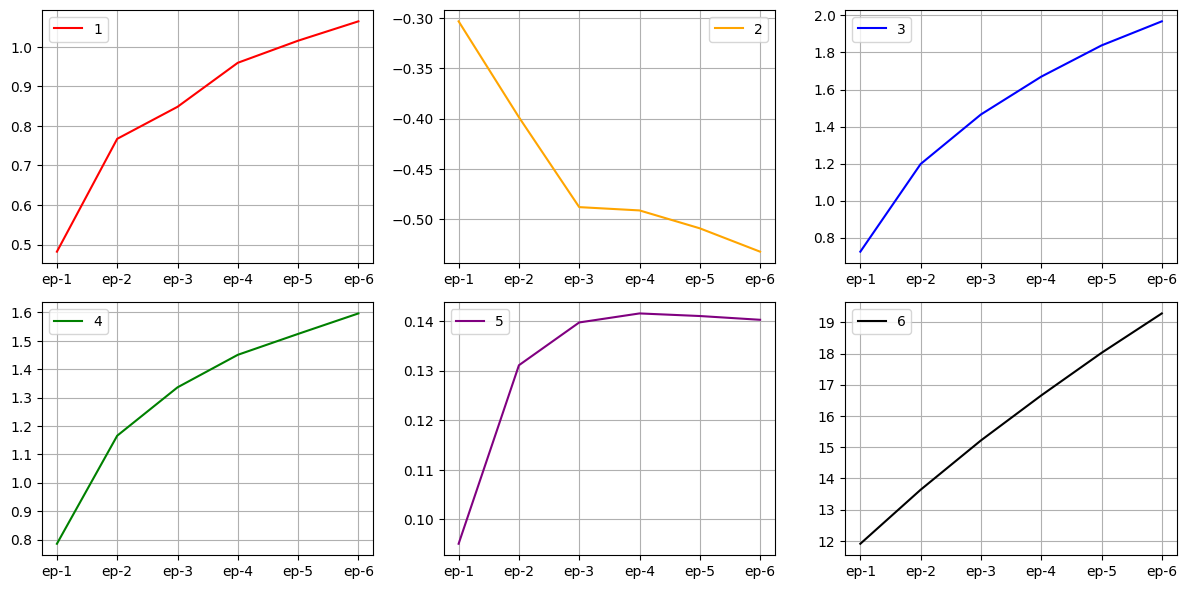

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 6))

ax1.grid(axis='both')
ax1.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_proj_1"] for v in stats_dict.values()], label = "1", color="red")
ax1.legend()

ax2.grid(axis='both')
ax2.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_noise_proj"] for v in stats_dict.values()], label = "2", color="orange")
ax2.legend()

ax3.grid(axis='both')
ax3.plot(["ep-%d"%x for x in stats_dict.keys()], [v["var_proj_1"] for v in stats_dict.values()], label = "3", color="blue")
ax3.legend()

ax4.grid(axis='both')
ax4.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_proj_2"] for v in stats_dict.values()], label = "4", color="green")
ax4.legend()

ax5.grid(axis='both')
ax5.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_sim"] for v in stats_dict.values()], label = "5", color="purple")
ax5.legend()

ax6.grid(axis='both')
ax6.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_mag"] for v in stats_dict.values()], label = "6", color="black")
ax6.legend()

fig.tight_layout()
fig.show()

# Visualize vectors

In [ ]:
test_index = 50

trg = list(test_dict.keys())[test_index]

print("Visuaizing for: %s" % (trg))

Visuaizing for: saving


In [ ]:
tsne = TSNE(n_components=3, perplexity=18, random_state=42)

for idx in range(len(models3)):

  #print("\n\n------ Plot for Epoch #%d ------\n" % (idx+1))

  target_vectors = models3[idx].embedding_input_dictionary()
  context_vectors = models3[idx].embedding_output_dictionary()

  ######################### Dimension Reduction

  vectors = [context_vectors[w] for w in test_dict[trg]["pos"]]
  vectors.extend([context_vectors[w] for w in test_dict[trg]["neg"]])
  vectors.append(target_vectors[trg])

  vectors = tsne.fit_transform(np.array(vectors))
  contexts = vectors[:nr_contexts]
  noises = vectors[nr_contexts:-1]
  target = vectors[-1]

  ########### Plot

  c_x, c_y, c_z = contexts[:, 0], contexts[:, 1], contexts[:, 2]
  n_x, n_y, n_z = noises[:, 0], noises[:, 1], noises[:, 2]
  t_x, t_y, t_z = target[0], target[1], target[2]

  hover_context = test_dict[trg]["pos"]
  hover_noise = test_dict[trg]["neg"]

  fig = go.Figure( data = [ go.Scatter3d( x = c_x, y = c_y, z = c_z, mode='markers',
      marker=dict(size=6, color="green", opacity=0.8),
      text = hover_context, hoverinfo = 'text', name = "Contexts") ] )

  fig.add_trace( go.Scatter3d( x = n_x, y = n_y, z = n_z, mode='markers',
      marker=dict(size=6, color="red", opacity=0.8),
      text = hover_noise, hoverinfo = 'text', name = "Noises" ) )

  fig.add_trace( go.Scatter3d( x=[0, t_x], y=[0, t_y], z=[0, t_z],
      mode='lines', text = trg, hoverinfo='text',
      line=dict(color='blue', width=3), name = trg  ) )

  ########### Add origin
  fig.add_trace( go.Scatter3d( x=[0, 0], y= [0, 0], z=[0, 0], mode='markers', text = "Origin", hoverinfo='text',
      marker=dict(size=5, color="black", opacity=1.0), name = "Origin"  ) )

  fig.update_layout(scene = dict(xaxis_title='x-axis', yaxis_title='y-axis', zaxis_title='z-axis'))
  #fig.show()

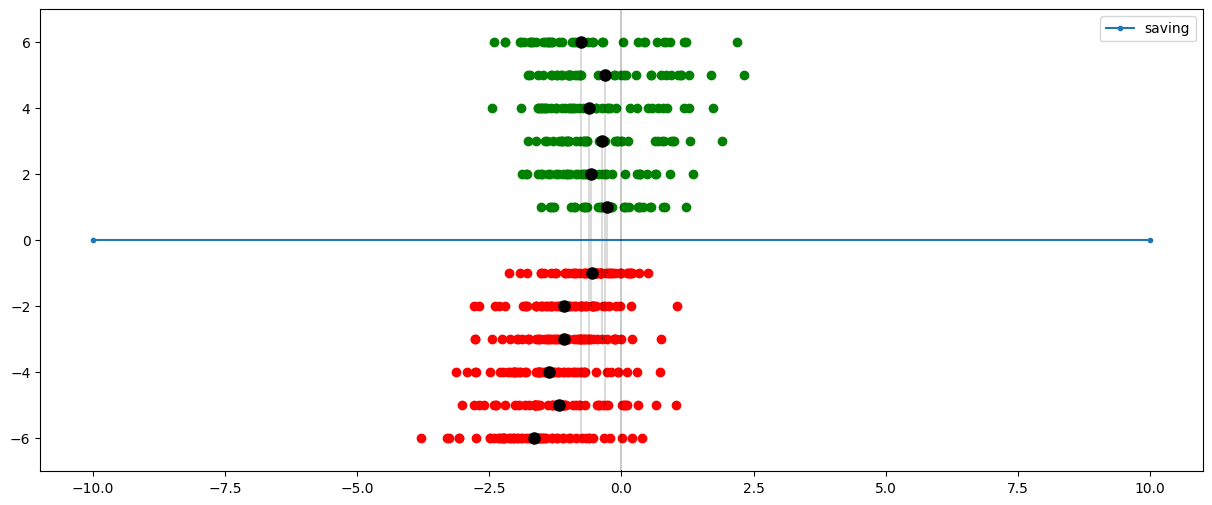

In [ ]:
test_index = 50
trg = list(test_dict.keys())[test_index]
contexts = test_dict[trg]["pos"]
noises = test_dict[trg]["neg"]

plt.figure(figsize=(15,6))

for epoch in range(len(models3)):
  target_vectors = models3[epoch].embedding_input_dictionary()
  context_vectors = models3[epoch].embedding_output_dictionary()

  context_projections = [orthogonal_projection_position(trg, context, target_vectors, context_vectors) for context in contexts]
  noise_projections = [orthogonal_projection_position(trg, context, target_vectors, context_vectors) for context in noises]

  plt.scatter(context_projections, [epoch+1] * len(context_projections), color="green")
  plt.scatter([statistics.mean(context_projections)], [epoch+1], color="black", linewidths=3.0)
  x1, y1 = [statistics.mean(context_projections), statistics.mean(context_projections)], [-(epoch+1), (epoch+1)]
  plt.plot(x1, y1, marker = ',', color="black", linewidth=0.2)

  plt.scatter(noise_projections, [-(epoch+1)] * len(noise_projections), color="red")
  plt.scatter([statistics.mean(noise_projections)], [-(epoch+1)], color="black", linewidths=3.0)

#magnitude = math.sqrt(sum(i**2 for i in target_vectors[trg]))
magnitude = 10.0
x1, y1 = [-magnitude, +magnitude], [0, 0]
plt.plot(x1, y1, marker = '.', label=trg)

x1, y1 = [0, 0], [-(epoch+2), (epoch+2)]
plt.plot(x1, y1, marker = ',', color="black", linewidth=0.3)

plt.legend()
plt.ylim((-(epoch+2), (epoch+2)))
plt.show()